In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [2]:
from enum import Enum
class State(Enum):
    Normal = 1
    VetoSignalling = 2
    VetoSignallingDeactivation = 3
    VetoCooldown = 4

In [3]:
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(Path('../../results/simulations/veto_signalling_loop/'))

In [4]:
total_balance = timestep_data_df_full.groupby('run_id').actors_total_balance.first()
timestep_data_df_full.actors_total_locked_relative = timestep_data_df_full.actors_total_locked / timestep_data_df_full.run_id.map(total_balance)

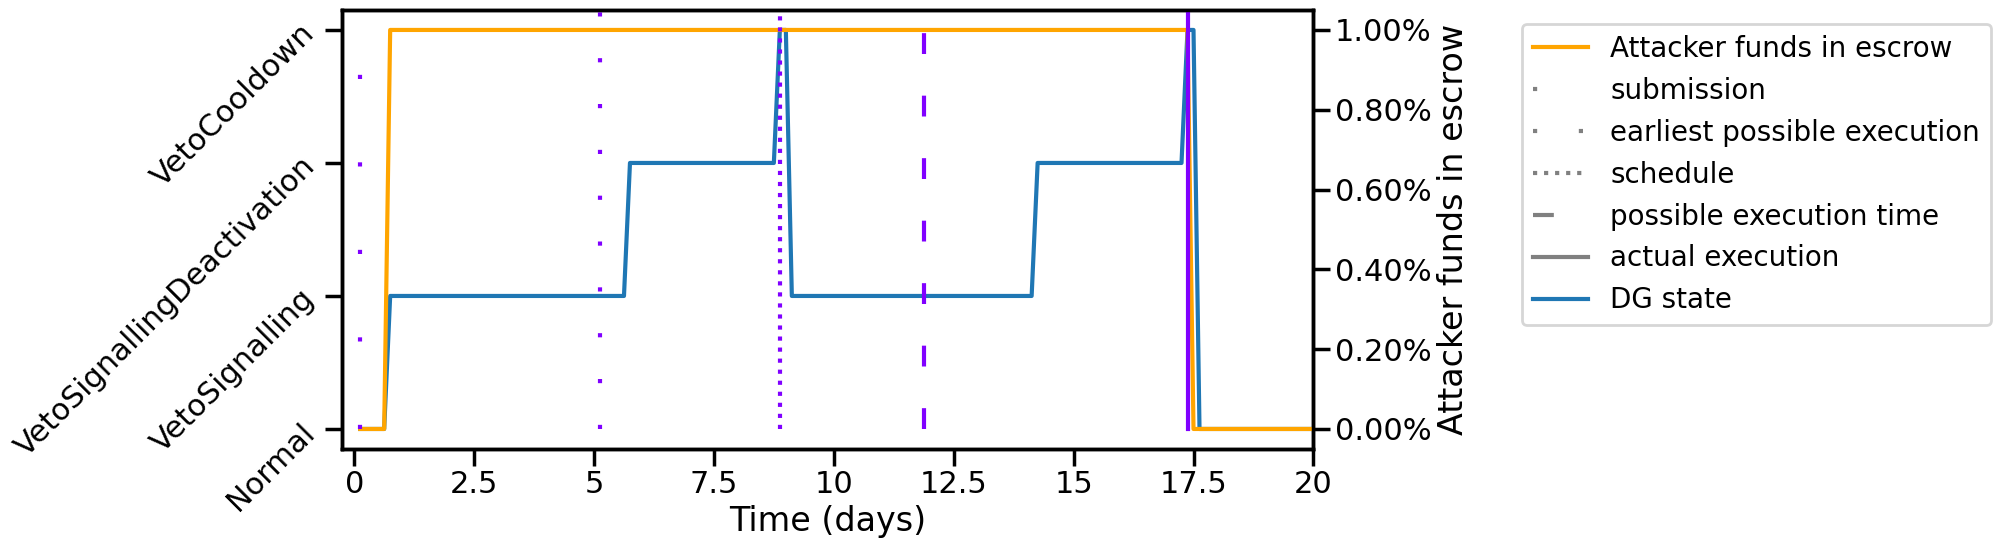

In [15]:
from matplotlib.ticker import PercentFormatter, FuncFormatter
from experiments.analysis_utils.visualization import add_proposal_data_to_timeplot

run_id = 5
timestep_data_df = timestep_data_df_full[timestep_data_df_full.run_id == run_id]
proposal_df = proposal_df_full[proposal_df_full.run_id == run_id]

sns.set_context("poster")
plt.figure(figsize=(22, 6))
line = plt.plot(timestep_data_df.timestep, timestep_data_df.dg_state_value, label='DG state')
plt.gca().set_yticks([state.value for state in State])
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: State(int(x)).name))
plt.gca().tick_params(axis='y', labelrotation=45)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{(x * 3 / 24):n}'))
plt.xlabel('Time (days)')

ax1 = plt.gca().twinx()
ax1.plot(timestep_data_df.timestep, timestep_data_df.actors_total_locked_relative, color='orange', label='Attacker funds in escrow')
ax1.set_ylabel('Attacker funds in escrow')
ax1.yaxis.set_major_formatter(PercentFormatter(1))

plt.xlim(-2, 160)

add_proposal_data_to_timeplot(ax1, proposal_df, proposal_legend=False)

# Adjust the legend to be outside the plot
handles, labels = ax1.get_legend_handles_labels()
handles += [line[0]]
labels += [line[0].get_label()]
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.2, 1), fontsize='small', frameon=True)

# Use a tight layout
plt.tight_layout()

,execution_delay,execution_delay_days
attacker_share,,
0.01,138,17.25
0.02,208,26.00
0.03,280,35.00
0.04,350,43.75
0.05,422,52.75
0.06,492,61.50
0.07,564,70.50
0.08,634,79.25
0.09,706,88.25


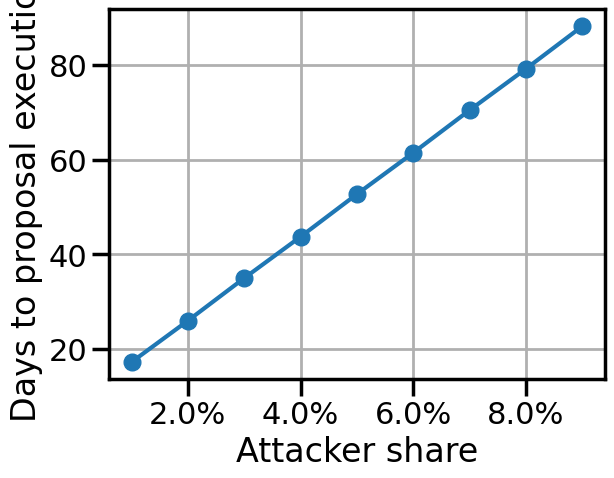

In [6]:
proposal_df_full['execution_delay'] = proposal_df_full.executedAt - proposal_df_full.submittedAt
proposal_df_full['schedule_delay'] = proposal_df_full.scheduledAt - proposal_df_full.submittedAt
proposal_df_full['execution_delay_hours'] = proposal_df_full.execution_delay * 3
proposal_df_full['schedule_delay_hours'] = proposal_df_full.schedule_delay * 3
proposal_df_full['execution_delay_days'] = proposal_df_full.execution_delay_hours / 24
proposal_df_full['schedule_delay_days'] = proposal_df_full.schedule_delay_hours / 24

first_proposal_df_full_with_params = proposal_df_full.groupby('run_id').first().merge(start_data_df_full, on='run_id')
first_proposal_df_full_with_params.sort_values('attacker_share', inplace=True)
display(first_proposal_df_full_with_params[['execution_delay', 'execution_delay_days', 'attacker_share']].set_index('attacker_share').sort_index())
plt.plot(first_proposal_df_full_with_params.attacker_share, first_proposal_df_full_with_params.execution_delay_days, marker='o')
plt.ylabel('Days to proposal execution')
plt.xlabel('Attacker share')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.grid(True);

In [7]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id')
# Filter out normal timesteps
filtered_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params.dg_state_name != 'Normal']

# Calculate the veto loop duration for each attacker_share
veto_loop_duration = filtered_df.groupby('attacker_share').size()

# Count occurrences of each unique dg_state_name for each run_id
state_counts = filtered_df.groupby(['attacker_share', 'dg_state_name']).size().unstack(fill_value=0)

# Calculate ratios of each unique dg_state_name
state_ratios = state_counts.div(state_counts.sum(axis=1), axis=0)

# Display the results
print("\nVeto loop duration for each attacker_share (days):")
print(veto_loop_duration * 3 / 24)


Veto loop duration for each attacker_share (days):
attacker_share
0.01    16.875
0.02    25.625
0.03    34.625
0.04    43.375
0.05    52.375
0.06    61.125
0.07    70.125
0.08    78.875
0.09    87.875
dtype: float64


In [8]:
print("\nDuration of each Dual Governance State for each attacker_share (days):")
print(state_counts * 3 / 24)


Duration of each Dual Governance State for each attacker_share (days):
dg_state_name   VetoCooldown  VetoSignalling  VetoSignallingDeactivation
attacker_share                                                          
0.01                     0.5          10.125                        6.25
0.02                     0.5          18.875                        6.25
0.03                     0.5          27.875                        6.25
0.04                     0.5          36.625                        6.25
0.05                     0.5          45.625                        6.25
0.06                     0.5          54.375                        6.25
0.07                     0.5          63.375                        6.25
0.08                     0.5          72.125                        6.25
0.09                     0.5          81.125                        6.25


In [9]:
print("\nRatios of each Dual Governance State for each attacker_share:")
print(state_ratios)


Ratios of each Dual Governance State for each attacker_share:
dg_state_name   VetoCooldown  VetoSignalling  VetoSignallingDeactivation
attacker_share                                                          
0.01                0.029630        0.600000                    0.370370
0.02                0.019512        0.736585                    0.243902
0.03                0.014440        0.805054                    0.180505
0.04                0.011527        0.844380                    0.144092
0.05                0.009547        0.871122                    0.119332
0.06                0.008180        0.889571                    0.102249
0.07                0.007130        0.903743                    0.089127
0.08                0.006339        0.914422                    0.079239
0.09                0.005690        0.923186                    0.071124
